# Project Description 

Given information about the user first transaction on the site, build a model to predict the probability that the first transaction of a new user is fraudulent.

# Dataset

- user_id : Id of the user. Unique for each user

- signup_time : the time when the user created her account (GMT time)

- purchase_time : the time when the user bought the item (GMT time)

- purchase_value : the cost of the item purchased (USD)

- device_id : the device id. Unique for each device. I.e., same device ID means that the same physical device was used for the transaction

- source : user marketing channel: ads, SEO, Direct 

- browser : the browser used by the user

- sex :  Male/Female

- age : user age

- ip_address : user numeric ip address

- class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0)

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import roc_curve

In [46]:
data=pandas.read_csv("Fraud_Data.csv")
data['ip_address']=round(data['ip_address'])
  
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


Use the second dataset to get user country based on Ip address. For each country, it has a range for possible Ip address. If the numeric ip address falls within that range, then the ip address belongs to the corresponding country:

In [47]:
ip_addresses=pandas.read_csv('IpAddress.csv')
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [48]:
# Determin user country based on Ip address
data_country = [None] * data.shape[0]
  
for i in range(data.shape[0]):
    tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & 
                       (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])]['country'].values
    if (len(tmp) == 1):  
        data_country[i] = tmp


In [49]:
data['country'] = data_country
data['country'] = data['country'].str.get(0)

In [50]:
print(data.groupby('country').size())

country
Afghanistan                6
Albania                   13
Algeria                  122
Angola                    24
Antigua and Barbuda        3
                        ... 
Viet Nam                 550
Virgin Islands (U.S.)      3
Yemen                      1
Zambia                    10
Zimbabwe                   6
Length: 181, dtype: int64


In [51]:
print(data.groupby('country').size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


# Exploratory Data Analysis

In [52]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [53]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209300e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [60]:
# certain country has highrt fraud rate
group_by_country = data.groupby(['country'])['class'].mean()
group_by_country_df = pd.DataFrame(index = group_by_country.index,columns= ['fraud_rate'] )
group_by_country_df['fraud_rate'] = group_by_country.values
group_by_country_df.sort_values(by=['fraud_rate'], ascending = False)

,fraud_rate
country,
Turkmenistan,1.000000
Namibia,0.434783
Sri Lanka,0.419355
Luxembourg,0.388889
Virgin Islands (U.S.),0.333333
...,...
Guadeloupe,0.000000
Gibraltar,0.000000
Ghana,0.000000


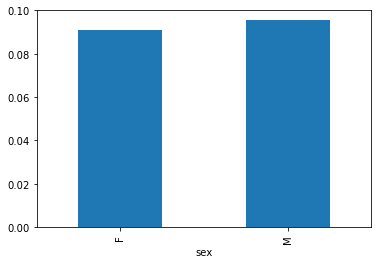

In [65]:
data.groupby(['sex'])['class'].mean().plot.bar()
plt.show()

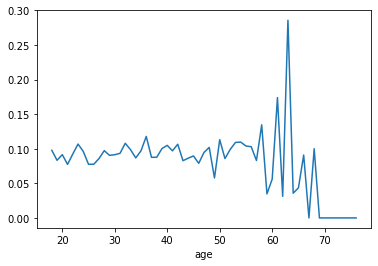

In [66]:
data.groupby(['age'])['class'].mean().plot()
plt.show()

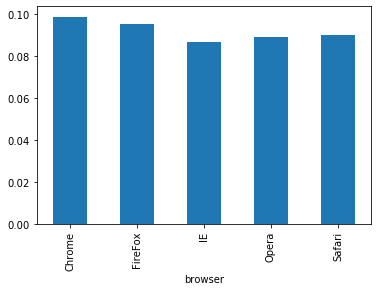

In [67]:
data.groupby(['browser'])['class'].mean().plot.bar()
plt.show()

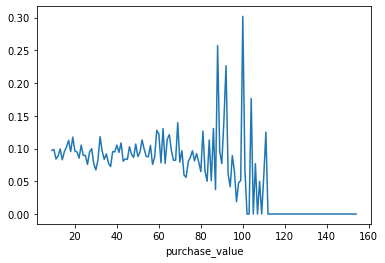

In [68]:
# purchase of more expensive items are more likely to be fraud
data.groupby(['purchase_value'])['class'].mean().plot()
plt.show()

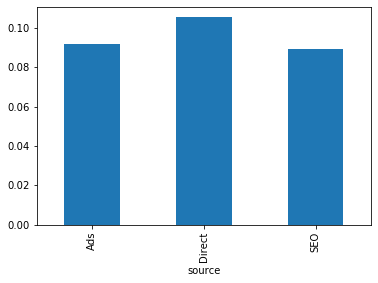

In [69]:
data.groupby(['source'])['class'].mean().plot.bar()
plt.show()

# Feature Engineering 

create new powerful variable such as:

- Time difference between sign-up time and purchase time


- If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)


- Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts


In [72]:
#convert data
data["signup_time"]   = pandas.to_datetime(data["signup_time"])
data["purchase_time"] = pandas.to_datetime(data["purchase_time"])
#take the difference
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()

In [77]:
data['purchase_signup_diff'].describe()

count    1.511120e+05
mean     4.932029e+06
std      3.126263e+06
min      1.000000e+00
25%      2.186754e+06
50%      4.926346e+06
75%      7.644525e+06
max      1.036797e+07
Name: purchase_signup_diff, dtype: float64

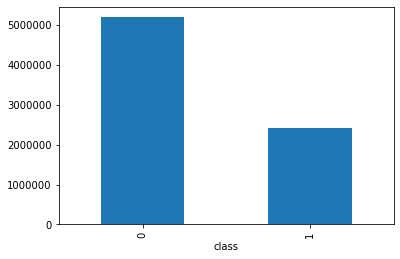

In [82]:
# fraud activities tend to have a shorter time difference 
data.groupby(['class'])['purchase_signup_diff'].mean().plot.bar()
plt.show()

In [86]:
#check how for each device id, how many different users had it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
  

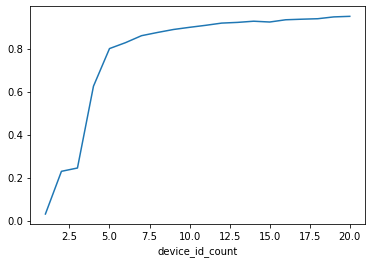

In [90]:
# users who use shared devices are more likely to perform fraud activity
data.groupby(['device_id_count'])['class'].mean().plot()
plt.show()

In [91]:
#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

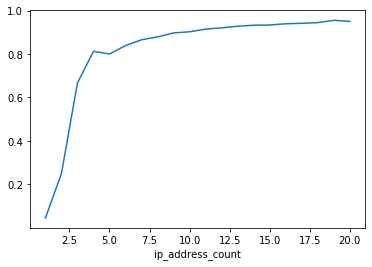

In [92]:
# users with same ip Address are more likely to commit fraud
data.groupby(['ip_address_count'])['class'].mean().plot()
plt.show()

# Random Forest 



Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model


Your boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?


Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?


In [93]:
np.random.seed(46)
  
#data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)
  
#replace None in the country var with "Not_found"
data_rf['country'].replace([None], "Not_found", inplace=True)
  
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)
  
#make dummy
data_rf = pandas.get_dummies(data_rf, drop_first=True) 
  
#split into train and test 
train, test = train_test_split(data_rf, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9559824732034532 
 OOB Confusion Matrix 
        0     1
0  90251   106
1   4284  5092


In [94]:
# print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.956305105198622 
 Test Set Confusion Matrix 
        0     1
0  46573    31
1   2214  2561


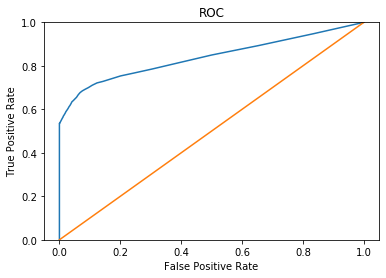

In [97]:
#cut-off analysis
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))
#get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [98]:

error_cutoff=pandas.DataFrame({'cutoff':pandas.Series(thresholds),
                               'class0_error':pandas.Series(fpr),
                               'class1_error': 1 - pandas.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
57    0.14      0.075358      0.314974       0.609668


The best value is in the area near 65% true positive rate (specifically 1-0.32 = 0.68) and very low false positive rate (~7%). You can find the corresponding point on the ROC curve.

In [99]:
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]

In [110]:
def calculate_metric(cutoff):
    pred = np.where(pred_prob > cutoff, 1, 0)
    accuracy = np.sum(pred ==test['class'])/len(test['class'])
    tpr = np.sum((pred == test['class'] )& (pred == 1))/np.sum(test['class'] == 1)
    fpr = np.sum((pred == 1 )& (test['class']  == 0))/np.sum(test['class'] == 0)
    return accuracy, tpr, fpr

In [111]:
calculate_metric(0.14)

(0.9084840109772475, 0.6768586387434555, 0.06778388121191314)

In [113]:
calculate_metric(0.05)

(0.7569240351116214, 0.7667015706806283, 0.24407776156553085)

In [114]:
calculate_metric(0.5)

(0.956305105198622, 0.5363350785340314, 0.000665178954596172)

In [103]:
# test accuracy with cutoff point 0.14
np.sum(pred ==test['class'])/len(test['class'])

0.9084840109772475

In [106]:
np.sum((pred == test['class'] )& (pred == 1))

3232

In [107]:
np.sum((pred == test['class'] )& (pred == 1))/np.sum(test['class'] == 1)

0.6768586387434555